# PHYS 7730 (Data Science) Midterm Summary
By Kaixin Wang(collector) and Prof. Michael Vershinin

[MidtermProject.pdf](MidtermProject.pdf)

In [1]:
%reset -f
import numpy as np
import scipy.optimize as SciOpt
import scipy.stats as SciStat
import scipy.signal as SciSign
import scipy.special as SciSpec
from numpy import random as rnd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2

In [2]:
#We will start with two peaks, 10000 i.i.d.r.v.'s in total
N1=int(3333); N2=int(6667); N=int(1e4);
#So let's get those r.v.'s. We can set the peak parameters now
d1=rnd.normal(-1,.5, N1); d2=rnd.normal(1,.5,N2)
#Let's mix these data set together into a sorted dataset
data=np.sort(np.concatenate((d1, d2), axis=0)).flatten(); 

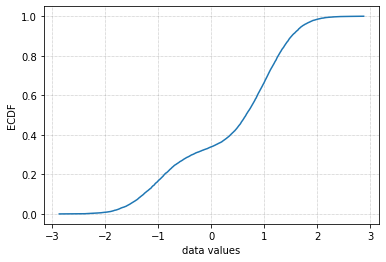

In [7]:
#Part 1: generate ECDF
ecdfY=np.linspace(1,N,N)/N
ecdfX=np.sort(data)
plt.plot(ecdfX,ecdfY)
plt.xlabel('data values')
plt.ylabel('ECDF')
#Add some grid lines and make nice
plt.grid(color='gray', linestyle='dotted', linewidth=.5);
plt.grid(visible=True);
#plt.tick_params(axis='x', labelbottom=False);
plt.yticks(size = 10);

The left peak is at -1.003432602658006
The right peak is at 1.004734237488386


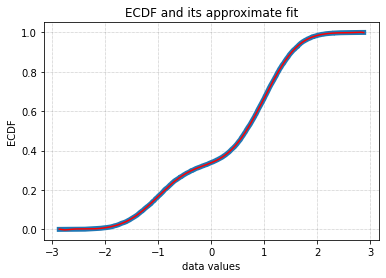

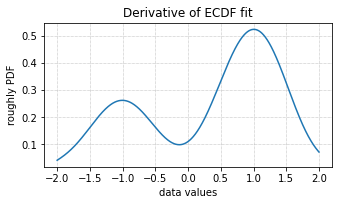

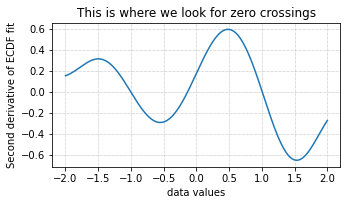

In [9]:
#One thing that might occur to us is that PDF
#is just a derivative of CDF so maximal PDF is 
#same as maximal slope of CDF
#So we just differentiate the ECDF and look for 
#maxima... But ECDF is "noisy". We can fit it to
#a smooth curve and differentiate that instead.
#For example: fit ECDF to a polynomial
p=np.polyfit(ecdfX, ecdfY,15)  ### return polynomial coefficients
plt.plot(ecdfX,ecdfY,linewidth=5)
plt.plot(ecdfX,np.polyval(p,ecdfX),'r')  ### returns y values
plt.title('ECDF and its approximate fit')
plt.xlabel('data values')
plt.ylabel('ECDF')
#Add some grid lines and make nice
plt.grid(color='gray', linestyle='dotted', linewidth=.5);
plt.grid(visible=True);
#plt.tick_params(axis='x', labelbottom=False);
plt.yticks(size = 10);
plt.plot();
#
#Now we can differentiate the polynomial we got
#to see the PDF, although this is not going to be 
#exactly right but close enough to eyeball it
p1=np.polyder(p);  ### return the derivative of the specified order of a polynomial
#Create plot for the results
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
#plot the result, minding that near the edges the fit is
#not as good but we can just ignore that part of the curve
plt.plot(ecdfX[(ecdfX>-2) & (ecdfX<2)],np.polyval(p1,ecdfX[(ecdfX>-2) & (ecdfX<2)]));
plt.title('Derivative of ECDF fit')
plt.xlabel('data values')
plt.ylabel('roughly PDF')
#Add some grid lines and make nice
plt.grid(color='gray', linestyle='dotted', linewidth=.5);
plt.grid(visible=True);
#plt.tick_params(axis='x', labelbottom=False);
plt.yticks(size = 10);
plt.plot();
#
#Now we can differentiate the polynomial we got twice
#to get peak locations
p2=np.polyder(p,m=2);
#Create plot for the results
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
#plot the result, minding that near the edges the fit is
#not as good but we can just ignore that part of the curve
plt.plot(ecdfX[(ecdfX>-2) & (ecdfX<2)],np.polyval(p2,ecdfX[(ecdfX>-2) & (ecdfX<2)]));
plt.title('This is where we look for zero crossings')
plt.xlabel('data values')
plt.ylabel('Second derivative of ECDF fit')
#Add some grid lines and make nice
plt.grid(color='gray', linestyle='dotted', linewidth=.5);
plt.grid(visible=True);
#plt.tick_params(axis='x', labelbottom=False);
plt.yticks(size = 10);
plt.plot();
#
rts=np.roots(p2);  ### return the roots of a polynomial with coefficients given in p(coefficients)
#We can exclude complex roots
rts=np.real(rts[np.isreal(rts)])
#and we can just select the roots we seek
leftLoc=rts[(rts>-1.5) & (rts<-.5)]
print('The left peak is at ' + str(leftLoc[0]))
rightLoc=rts[(rts<1.5) & (rts>.5)]
print('The right peak is at ' +str(rightLoc[0]))

In [10]:
#Now let's set this up for bootstrap for left peak
def leftroot(data):
    N=len(data)
    ecdfY=np.linspace(1,N,N)/N
    ecdfX=np.sort(data)
    p=np.polyfit(ecdfX, ecdfY,15)
    p2=np.polyder(p,m=2);
    rts=np.roots(p2);
    rts=np.real(rts[np.isreal(rts)])
    ret=rts[(rts>-1.5) & (rts<-.5)]
    return ret[0]
#------------------------------------
#And run bootstrap
data1=(data,)
resL = SciStat.bootstrap(data1, leftroot, confidence_level=0.95,vectorized=False)
print(resL.confidence_interval)
loL=resL.confidence_interval.low
hiL=resL.confidence_interval.high
midL=(hiL+loL)/2
errL=(hiL-loL)/2

ConfidenceInterval(low=-1.0523568731104298, high=-0.9589678224693151)


In [11]:
#Now let's set this up for bootstrap for right peak
def rightroot(data):
    N=len(data)
    ecdfY=np.linspace(1,N,N)/N
    ecdfX=np.sort(data)
    p=np.polyfit(ecdfX, ecdfY,15)
    p2=np.polyder(p,m=2);
    rts=np.roots(p2);
    rts=np.real(rts[np.isreal(rts)])
    ret=rts[(rts<1.5) & (rts>.5)]
    return ret[0]
#------------------------------------
#And run bootstrap
data1=(data,)
resR = SciStat.bootstrap(data1, rightroot, confidence_level=0.95,vectorized=False)
print(resR.confidence_interval)
loR=resR.confidence_interval.low
hiR=resR.confidence_interval.high
midR=(loR+hiR)/2
errR=(hiR-loR)/2

ConfidenceInterval(low=0.9689650931690523, high=1.0401018562419153)


In [12]:
#Last but not least
sep=np.round(rightLoc[0]-leftLoc[0],decimals=3)
err=np.round(np.sqrt(errL*errL+errR*errR),decimals=3)
print('Peak separation is ' + str(sep) + u"\u00B1" + str(err))

Peak separation is 2.008±0.059


In [13]:
#Another way to solve this part of the assignment is to just
#fit the ecdf to cdf and then run the fit through bootstrap
#to get error bars
#First we define the cost function
#This can be defined once
cost=lambda p,ECDF: LA.norm(p[0]*SciStat.norm.cdf(ECDF["X"], loc=p[1], scale=p[3])+\
                    (1-p[0])*SciStat.norm.cdf(ECDF["X"], loc=p[2], scale=p[4])-ECDF["Y"])
#We estimate parameters for the whole data set to get great starting guesses
ecdf={"X": np.sort(data),
      "Y": np.linspace(1,N,N)/N}
p0=SciOpt.minimize(cost,np.array([.5,-2,2,1,1]),args=ecdf)  ### Minimization of scalar function of one or more variables
def sep(rvs): 
    sz=len(rvs)
    ecdf={"X": np.sort(rvs),
          "Y": np.linspace(1,sz,sz)/sz}
    #Optimize parameters
    params=SciOpt.minimize(cost,p0.x,args=ecdf)
    #return peak separation for a given resample
    return params.x[2]-params.x[1]
#Perform bootstrap
res = SciStat.bootstrap((data,), sep, \
                              confidence_level=0.95,vectorized=False)
print('The C.I. is : ')
print((res.confidence_interval.low,res.confidence_interval.high))
#This is better than taking derivatives in terms of precision (the error bars
#are about 2X to 3X smaller) but it is relatively slow to compute (about 36 mins to macbookpro)

The C.I. is : 
(1.9779326059844977, 2.0323203147172477)


In [25]:
#Part 2a: First we do ExMax with MLE maximization
#
#define Gaussian pdf function
G = lambda d, mu, sig : 1/((np.sqrt(2*np.pi)*sig)*np.exp(np.power(d-mu,2)/(2*sig*sig)));
#
#define initial guesses
sz1=0.5; sz2=0.5; 
#We use some initial guesses. 
#Something like an eyeball estimate for locations but 
#with a deliberate error to make convergence evident
mu1=-2; 
mu2=2; 
#Let's give it some overly large gammas to start
sig1=2; 
sig2=2;
#
#Now we iterate
#Our parameter array has initial guesses
par=np.array([mu1, mu2, mu1, mu2])
#and just to start the loop, the old parameter array
#is filled with zeros
par_old=np.array([0, 0, 0, 0])
#While parameters are changing appreciably 
#in each loop iteration
while LA.norm(par-par_old)>1e-14:
    #find cluster probabilities for each point
    G1=G(data, mu1, sig1) 
    G2=G(data, mu2, sig2)
    #point probabilities are just weighted with cluster sizes
    w1=np.divide(sz1*G1, sz1*G1+sz2*G2)
    w2=np.divide(sz2*G2, sz1*G1+sz2*G2)
    #now recompute cluster sizes
    sz1=np.sum(w1)/np.size(data)
    sz2=np.sum(w2)/np.size(data)
    #Now do maximization
    M1= lambda p : np.sum(np.multiply(w1,data-p))
    mu1= SciOpt.fsolve(M1,mu1);
    M2= lambda p : np.sum(np.multiply(w2,data-p))
    mu2= SciOpt.fsolve(M2,mu2);
    S1= lambda p : np.sum(np.multiply(w1,np.power(data-mu1,2)-p*p))
    sig1=SciOpt.fsolve(S1,sig1);
    S2= lambda p : np.sum(np.multiply(w2,np.power(data-mu2,2)-p*p))
    sig2=SciOpt.fsolve(S2,sig2);
    #Newly found parameter estimates are moved into par vector
    #Old parameters are moved into par_old vector
    par_old=par;
    par=np.array([mu1, mu2, sig1, sig2]);
#Show results 
print('The positive peak has location ', par[1], ' and sigma ', par[3]); 
print('The negative peak has location ', par[0], ' and sigma ', par[2]); 
print('The positive peak has weight ', sz2); 
print('The negative peak has weight ', sz1); 
err1=1.96*par[3]/np.sqrt(sz1*N)  ### 95% confidential interval as well as sig_sample = sig_ana/sqrt(N)
ciLo1=par[1]-err1; ciLo1=str(ciLo1[0])
ciHi1=par[1]+err1; ciHi1=str(ciHi1[0])
print('Positive peak C.I. is : ['+ciLo1+' ; '+ciHi1+']')
err2=1.96*par[3]/np.sqrt(sz1*N)
ciLo2=par[0]-err2; ciLo2=str(ciLo2[0])
ciHi2=par[0]+err2; ciHi2=str(ciHi2[0])
print('Negative peak C.I. is : ['+ciLo2+' ; '+ciHi2+']')
#Last but not least
sep=np.round(np.abs(par[0]-par[1]),decimals=4)
err=np.round(np.sqrt(err1*err1+err2*err2),decimals=4)
print('Peak separation is ' + str(sep[0]) + u"\u00B1" + str(err[0]))

The positive peak has location  [0.99470857]  and sigma  [0.50540832]
The negative peak has location  [-1.0106481]  and sigma  [0.50640527]
The positive peak has weight  0.670053557961226
The negative peak has weight  0.329946442038774
Positive peak C.I. is : [0.9774630293800572 ; 1.0119541040109525]
Negative peak C.I. is : [-1.0278936378548265 ; -0.9934025632239312]
Peak separation is 2.0054±0.0244


-0.9900531181763444  ;  1.0076287004258557
Separation point for left peak 0.005386370708888477
Separation point for right peak 0.007600540679322698


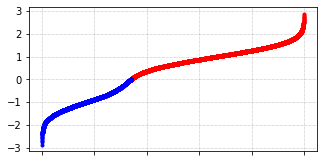

In [49]:
#Part 2b: Now we compare ExMax to K-means
#We expect fairly good things from K-means here: 
#clusters have same variances and have no outliers
#Create plot for the results
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
#Add some grid lines and dump to screen
plt.grid(color='gray', linestyle='dotted', linewidth=.5)
plt.grid(visible=True)
plt.tick_params(axis='x', labelbottom=False) 
plt.yticks(size = 10)
plt.gca().cla()   ### plt.gca() get current axes; plt.cla() clear all axes; 
#Do k-means
#Create starting guess for cluster centers
loc1=-2; loc2=2;
#and initialize looped parameter archive
loc1old=0; loc2old=0;
while np.power(loc1-loc1old,2)+np.power(loc2-loc2old,2)>.01:
    #The distance from all data points to each 
    #current estimate of cluster centers
    dist1=np.sqrt(np.power(data-loc1,2)); 
    dist2=np.sqrt(np.power(data-loc2,2));   
    #Push current center locations into archive
    loc1old=loc1; 
    loc2old=loc2; 
    #recompute cluster center locations
    loc1=np.median(data[dist1<dist2])  ### you can use np.mean
    loc2=np.median(data[dist1>dist2])  
#
data1=data.copy(); data1[dist1<dist2]=np.nan;
data2=data.copy(); data2[dist1>dist2]=np.nan;
#Add some grid lines and make nice
plt.grid(color='gray', linestyle='dotted', linewidth=.5)
plt.grid(visible=True)
plt.tick_params(axis='x', labelbottom=False) 
plt.yticks(size = 10)
#plot cluster 1 in red
plt.plot(data1,'r.')
#plot cluster 2 in blue
plt.plot(data2,'b.')
#tell the viewer final cluster center locations
print(loc1, ' ; ', loc2)
#Also let's find the border between clusters
border1=np.max(data2[~(np.isnan(data2))])
border2=np.min(data1[~(np.isnan(data1))])
print("Separation point for left peak " +str(border1))
print("Separation point for right peak "+str(border2))

In [54]:
#We have to assume that each cluster is Gaussian because K-Means
#does not let us see e.g. how many points from right Gaussian
#are on the left side of the separation. But we will still
#need to treat each Gaussian as truncated at the separation 
#One peak is left truncated and one is right truncated!
C=(border1+border2)/2
#Right truncation:
data1=data[(data<C)]
def logL(p):                                                      ### here, the f is pdf/cdf(cutoff) with truncation
    mu=p[0]; sigma=p[1]
    term1=-np.log(sigma)
    term2=-np.power(data1-mu,2)/(2*sigma*sigma)
    term3=-np.log(0.5+0.5*SciSpec.erf((C-mu)/(sigma*np.sqrt(2))))  ### use the cdf for right truncated
    return -np.sum(term1+term2+term3)    ### let it be negative log-likelihood (here is the positive), so you can just find the min of it
#--------------------------------
#Estimate the parameters (here mu and sigma)
#1 and 1 are some random starting guesses
Pr=SciOpt.minimize(logL,np.array([1, 1]),\
                bounds=((None,C),(1e-15,None))); ### bounds is the boundary of x and y, None is no boundary
#
#Left truncation:
data2=data[(data>C)]
def logL(p):
    mu=p[0]; sigma=p[1]
    term1=-np.log(sigma)
    term2=-np.power(data2-mu,2)/(2*sigma*sigma)
    term3=-np.log(0.5-0.5*SciSpec.erf((C-mu)/(sigma*np.sqrt(2))))   ### use the survival func for left truncated
    return -np.sum(term1+term2+term3)
#--------------------------------
#Estimate the parameters (here mu and sigma)
#1 and 1 are some random starting guesses
Pl=SciOpt.minimize(logL,np.array([1, 1]),\
                bounds=((C,None),(1e-15,None)));
#Let's start by estimating error bars without accounting for truncation
print('Ignoring truncation effect on error bars:')
err1=1.96*Pr.x[1]/np.sqrt(len(data1))
print('Negative peak is at ' + str(Pr.x[0]) + u"\u00B1" + str(err1))
err2=1.96*Pl.x[1]/np.sqrt(len(data2))
print('Positive peak is at ' + str(Pl.x[0]) + u"\u00B1" + str(err2))

Ignoring truncation effect on error bars:
Negative peak is at -0.9399478388994492±0.01863893077161689
Positive peak is at 0.9820525098780672±0.012402850777693064


In [61]:
#And here we do account for truncation
#Right truncation
#Start with PDF not normalized pdf for right peak
GrC=SciStat.norm.pdf(C,loc=Pr.x[0],scale=Pr.x[1])
#Next, find PDF normalization factor for right truncation
ArC=SciStat.norm.cdf(C,loc=Pr.x[0],scale=Pr.x[1])
#Now Fisher info for 1 r.v.
Finfo_r=(1/(Pr.x[1]*Pr.x[1]))-\
        GrC/(np.sqrt(2*np.pi)*Pr.x[1]*ArC*ArC)+\
        (Pr.x[0]-C)*GrC/(Pr.x[1]*Pr.x[1]*ArC)       ### you can calculate -(logf(x))'' on the mean average by sympy or mathematica
err1F=1.96/np.sqrt(len(data1)*Finfo_r)
#Left truncation
#Start with PDF not normalized pdf for left peak
GlC=SciStat.norm.pdf(C,loc=Pl.x[0],scale=Pl.x[1])
#Next, find PDF normalization factor for right truncation
AlC=1-SciStat.norm.cdf(C,loc=Pl.x[0],scale=Pl.x[1])
#Now Fisher info for 1 r.v.
Finfo_l=(1/(Pl.x[1]*Pl.x[1]))-\
        GlC/(np.sqrt(2*np.pi)*Pl.x[1]*AlC*AlC)-\
        (Pl.x[0]-C)*GlC/(Pl.x[1]*Pl.x[1]*AlC)
err2F=1.96/np.sqrt(len(data2)*Finfo_l)
#Now let's estimate error bars fully accounting for truncation
print('Accounting for truncation effect on error bars:')
print('Negative peak is at ' + str(Pr.x[0]) + u"\u00B1" + str(err1F))
print('Positive peak is at ' + str(Pl.x[0]) + u"\u00B1" + str(err2F))


Accounting for truncation effect on error bars:
Negative peak is at -0.9399478388994492±0.02092548754991169
Positive peak is at 0.9820525098780672±0.013505610271594252


In [60]:
### calculation details
'''
from sympy import *
x, sig, mu, c, = symbols('x sig mu c')
f = -ln(sig*sqrt(2*pi))-(x-mu)**2/2/sig**2-ln(1/2-1/2*erf((c-mu)/sig/sqrt(2)))
f
fp=diff(f,mu)
fp
fpp=-diff(fp,mu)
fpp
'''

"\nfrom sympy import *\nx, sig, mu, c, = symbols('x sig mu c')\nf = -ln(sig*sqrt(2*pi))-(x-mu)**2/2/sig**2-ln(1/2-1/2*erf((c-mu)/sig/sqrt(2)))\nf\nfp=diff(f,mu)\nfp\nfpp=-diff(fp,mu)\nfpp\n"

In [62]:
#Last but not least
sep=np.round(np.abs(Pr.x[0]-Pl.x[0]),decimals=3)
err=np.round(np.sqrt(err1*err1+err2*err2),decimals=3)
print('Ignoring truncation:')
print('    Peak separation is ' + str(sep) + u"\u00B1" + str(err))
errF=np.round(np.sqrt(err1F*err1F+err2F*err2F),decimals=3)
print('Accounting for truncation:')
print('    Peak separation is ' + str(sep) + u"\u00B1" + str(errF))
#The error bars do not change much when we account for truncation
#but truncation does introduce bias for both peak locations 
#(especially the smaller negative peak)
#and hence peak separation is estimated to be notably below ground truth

Ignoring truncation:
    Peak separation is 1.922±0.022
Accounting for truncation:
    Peak separation is 1.922±0.025


In [67]:
#Part 3
#Use method of moments to define separation
#It is easiest to work with raw moments
#For a Gaussian distribution, a raw moment of a given "order"
#is given by the below formula

[Central moment calculation on normal distribution](https://math.stackexchange.com/questions/92648/calculation-of-the-n-th-central-moment-of-the-normal-distribution-mathcaln)

[Raw moment calculation on normal distribution](https://math.stackexchange.com/questions/1945448/methods-for-finding-raw-moments-of-the-normal-distribution)

[Some intro to moments calculation](https://gregorygundersen.com/blog/2020/04/11/moments/)

[LibreTexts: Method of Moment](https://stats.libretexts.org/Bookshelves/Probability_Theory/Probability_Mathematical_Statistics_and_Stochastic_Processes_(Siegrist)/07%3A_Point_Estimation/7.02%3A_The_Method_of_Moments)

![MidtermHint.jpg](MidtermHint.jpg)
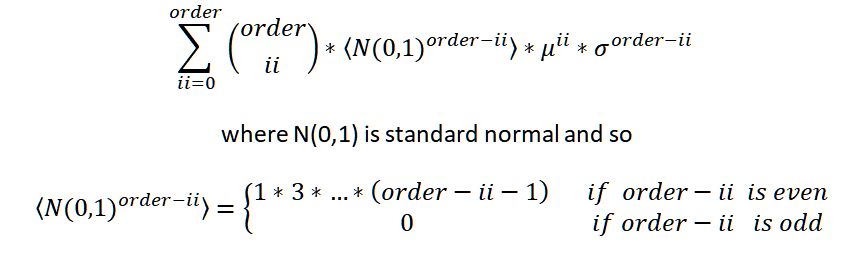

In [64]:
#Let's code this up
def ExpectN01(num):
    #This is a helper function which calculates <N(0,1)^(order-ii)>
    if (num % 2) == 0: #if argument is even
        ret=np.prod(np.arange(1,num,2))       ### product of all the elements in the array
    else:              #if argument is odd
        ret=0
    return ret
#------------------------------------
def rawMomentGaussian(order,mu,sig):
    #The raw moments of a single Gaussian are: 
    ret=0
    for ii in np.arange(order+1):
        ret+=ExpectN01(order-ii)*SciSpec.comb(order,ii)*\
             np.power(mu,ii)*np.power(sig,order-ii)
    return ret
#------------------------------------
def rawMomentGmix(order,p):
    #here we find the raw moments of a Gaussian mixture
    #A is between 0 and 1 so this is a hack to enforce it
    A=SciStat.norm.cdf(p[0]); 
    #no restrictions on mu
    mu1=p[1]; mu2=p[2]; 
    #Sigmas are non-negative so we enforce that too
    sig1=np.abs(p[3]); sig2=np.abs(p[4]);
    return  A*rawMomentGaussian(order,mu1,sig1)+\
            (1-A)*rawMomentGaussian(order,mu2,sig2)
#------------------------------------
def equations(p,rvvec):
    #now we just set up the five equatiions with five unknowns
    return (rawMomentGmix(1,p)-np.mean(np.power(rvvec,1)),\
            rawMomentGmix(2,p)-np.mean(np.power(rvvec,2)),\
            rawMomentGmix(3,p)-np.mean(np.power(rvvec,3)),\
            rawMomentGmix(4,p)-np.mean(np.power(rvvec,4)),\
            rawMomentGmix(5,p)-np.mean(np.power(rvvec,5)))
#------------------------------------
#I am admittedly giving it very good but not perfect starting guesses
guesses=np.array([-.5,-1.1,1.1,.45,.45])
p = SciOpt.fsolve(equations, guesses, args=data)
#Let's keep a copy of this estimate for later
pest=p; pest[0]= SciStat.norm.cdf(p[0]); pest[3]=np.abs(p[3]); pest[4]=np.abs(p[4]); 
print('The mixing coefficient is '      +str(pest[0]))
print('The mu of first Gaussian is '    +str(pest[1]))
print('The sigma of first Gaussian is ' +str(pest[3]))
print('The mu of second Gaussian is '   +str(pest[2]))
print('The sigma of second Gaussian is '+str(pest[4]))
#------------------------------------
sep=np.round(np.abs(mu1-mu2),decimals=3)
print('Peak separation is ' + str(sep[0]))

The mixing coefficient is 0.33005015413391103
The mu of first Gaussian is -1.0093160389818912
The sigma of first Gaussian is 0.5087485233278773
The mu of second Gaussian is 0.994362768584269
The sigma of second Gaussian is 0.5062350842998331
Peak separation is 2.005


In [65]:
#Now we need the C.I.
#First we do the bootstrap
#Warning: this step is slow
def peaksep(data):
    p =  SciOpt.fsolve(equations, guesses, args=data)
    return np.abs(p[1]-p[2])
dataBoot=(data,)
res = SciStat.bootstrap(dataBoot, peaksep, confidence_level=0.95,vectorized=False)
print(res.confidence_interval)  ### it spent 13 mins to calculate 

ConfidenceInterval(low=1.9774537762837527, high=2.029193180973888)


In [71]:
#And now MELE
#So the plan is to get error bars for all the raw moments
#and then to propagate all errors to the final answer
#-----------------------------------------------------------------
#To do MELE on all the raw moments, all we need is ELR for mean
def ELR(data,Val): 
    #data is (...wait for it...) the vector of data
    #Val is the tentative value for quantity being estimated
    #Lam is the Lagrange multiplier
    #-------------------------------------------------------
    #Define the estimating function
    g=data-Val
    #Set up the Lagrange mutiplier condition for Lam
    constraintEQN = lambda L : sum(np.divide(g,1 + g*L)); 
    #Find the multiplier
    Lam=SciOpt.fsolve(constraintEQN,0);
    #return the Empirical Likelihood Ratio
    return 2*np.sum(np.log(1+Lam*g))
#And now we are set to find MELE and error bar sizes
#for raw moments of the first 5 orders

In [72]:
data1=np.power(data,1); cen=np.mean(data1)
#Define cost function which sets target ELR based on confidence level
ELRiterator = lambda p : ELR(data1,p)-chi2.ppf(0.975, df=1); 
#Use brent method to find intersection point for ELR and cutoff...
#... on the right side of minimum
limHi=SciOpt.brentq(ELRiterator, cen, cen+0.1)  ### Find a root of a function in a bracketing interval using Brent’s method
#... on the left side of minimum
limLo=SciOpt.brentq(ELRiterator, cen-0.1, cen)
#Dump output to user
print('The 95% CI for MELE of raw moment of order 1:')
print((limLo, limHi))
#The CI is almost symmetric around actual moment 
#so we can just retain on error bat size for both
#lower and upper error bars
err1=np.max((limHi-cen, cen-limLo)); 

The 95% CI for MELE of raw moment of order 1:
(0.3089772776615217, 0.35694143441092674)


In [73]:
data2=np.power(data,2); cen=np.mean(data2)
#Define cost function which sets target ELR based on confidence level
ELRiterator = lambda p : ELR(data2,p)-chi2.ppf(0.975, df=1); 
#Use brent method to find intersection point for ELR and cutoff...
#... on the right side of minimum
limHi=SciOpt.brentq(ELRiterator, cen, cen+0.1)
#... on the left side of minimum
limLo=SciOpt.brentq(ELRiterator, cen-0.1, cen)
#Dump output to user
print('The 95% CI for MELE of raw moment of order 2:')
print((limLo, limHi))
#The CI is almost symmetric around actual moment 
#so we can just retain on error bat size for both
#lower and upper error bars
err2=np.max((limHi-cen, cen-limLo)); 

The 95% CI for MELE of raw moment of order 2:
(1.2318751681752504, 1.2801605812259882)


In [74]:
data3=np.power(data,3); cen=np.mean(data3); 
#Define cost function which sets target ELR based on confidence level
ELRiterator = lambda p : ELR(data3,p)-chi2.ppf(0.975, df=1); 
#Use brent method to find intersection point for ELR and cutoff...
#... on the right side of minimum
limHi=SciOpt.brentq(ELRiterator, cen, cen+0.1)
#... on the left side of minimum
limLo=SciOpt.brentq(ELRiterator, cen-0.1, cen)
#Dump output to user
print('The 95% CI for MELE of raw moment of order 3:')
print((limLo, limHi))
#The CI is almost symmetric around actual moment 
#so we can just retain on error bat size for both
#lower and upper error bars
err3=np.max((limHi-cen, cen-limLo)); 

The 95% CI for MELE of raw moment of order 3:
(0.5103086843300472, 0.6355663291248964)


In [75]:
data4=np.power(data,4); cen=np.mean(data4)
#Define cost function which sets target ELR based on confidence level
ELRiterator = lambda p : ELR(data4,p)-chi2.ppf(0.975, df=1); 
#Use brent method to find intersection point for ELR and cutoff...
#... on the right side of minimum
limHi=SciOpt.brentq(ELRiterator, cen, cen+0.2)
#... on the left side of minimum
limLo=SciOpt.brentq(ELRiterator, cen-0.2, cen)
#Dump output to user
print('The 95% CI for MELE of raw moment of order 4:')
print((limLo, limHi))
#The CI is almost symmetric around actual moment 
#so we can just retain on error bat size for both
#lower and upper error bars
err4=np.max((limHi-cen, cen-limLo));

The 95% CI for MELE of raw moment of order 4:
(2.63301833279619, 2.8471681849393957)


In [77]:
data5=np.power(data,5); cen=np.mean(data5)
#Define cost function which sets target ELR based on confidence level
ELRiterator = lambda p : ELR(data5,p)-chi2.ppf(0.975, df=1); 
#Use brent method to find intersection point for ELR and cutoff...
#... on the right side of minimum
limHi=SciOpt.brentq(ELRiterator, cen, cen+0.3)
#... on the left side of minimum
limLo=SciOpt.brentq(ELRiterator, cen-0.3, cen)
#Dump output to user
print('The 95% CI for MELE of raw moment of order 5:')
print((limLo, limHi))
#The CI is almost symmetric around actual moment 
#so we can just retain on error bat size for both
#lower and upper error bars
err5=np.max((limHi-cen, cen-limLo)); 

The 95% CI for MELE of raw moment of order 5:
(1.1797525370127147, 1.6993995603577932)


In [104]:
#The last thing we will need is the full Jacobian
#because we will next need to do error propagation 
#--------------------------------------------------------------------------
#Recall that fsolve returns fjac and R , i.e. the Q and R matrices
#which result from QR decomposition of the Jacobian
#R has that slightly compressed format too which we will need to understand 
#from documentation to reconstruct the full R matrix
#--------------------------------------------------------------------------
#The problem we have is that our previous estimate used transforms of
#parameters (e.g. A=SciStat.norm.cdf(p[0])) to enforce bounds
#However this will affect the Jacobian calculation
#so here we redo the fit with perfect initial guess which we already have
#and this way we can avoid putting constraints on variables and still
#get our Jacobian
def rawMomentGmix(order,p):
    #here we find the raw moments of a Gaussian mixture
    #We avoid any restrictions now
    A=p[0]
    mu1=p[1]; mu2=p[2]; 
    sig1=p[3]; sig2=p[4];
    return  A*rawMomentGaussian(order,mu1,sig1)+\
            (1-A)*rawMomentGaussian(order,mu2,sig2)
#------------------------------------
def equations(p,rvvec):
    #now we just set up the five equatiions with five unknowns
    return (rawMomentGmix(1,p)-np.mean(np.power(rvvec,1)),\
            rawMomentGmix(2,p)-np.mean(np.power(rvvec,2)),\
            rawMomentGmix(3,p)-np.mean(np.power(rvvec,3)),\
            rawMomentGmix(4,p)-np.mean(np.power(rvvec,4)),\
            rawMomentGmix(5,p)-np.mean(np.power(rvvec,5)))
#------------------------------------
#I am now giving it the perfect starting guesses
p, info, ier, mesg = SciOpt.fsolve(equations, pest, args=data, full_output=True)
#First we need to reconstruct R matrix
r = np.zeros((5, 5))
r[np.triu_indices(5)] = info['r']
#And now we invert the QR decomposition to get what we are after
J=info.get('fjac').dot(r)
#print(J)

In [105]:
#Now we just propagate errors
#The error bars on raw moments are
errorbars=np.array([err1, err2, err3, err4, err5])
#The slopes for each function are just relevant columns of J
#mu1 is variable #2 so the corresponding column is 1
#since we count from zero
mu1_err=LA.norm(errorbars/np.abs(J[:,1]));
#mu2 is variable #3 so the corresponding column is 2
#since we count from zero
mu2_err=LA.norm(errorbars/np.abs(J[:,2]));
sep_err=np.sqrt(mu1_err*mu1_err+mu2_err*mu2_err);
ciLO=sep-sep_err; ciLO=ciLO[0]
ciHI=sep+sep_err; ciHI=ciHI[0]
print('MELE CI is [' +str(ciLO)+' ; ' + str(ciHI)+']')
#The calculation is a bit numerically unstable so if you run this
#many times, error bars are occasionally not entirely on top of 
#each other between identically generated data sets
#but they are typically close to +/- 0.25
#This is quite a bit worse than bootstrap 
#We used five raw moments and such a high number(5) does inflate the error 

MELE CI is [1.730535684738237 ; 2.279464315261763]


In [107]:
#If we had assumed that A,sigma1,sigma2 were known and ran
#the MELE up to just second order, the CI would have been very close to
#the bootstrap result.
#We use the property that var(X)=<X^2>-<X>^2 to derive for the 
#mixture of two Gaussians:
#var(data)=A*sigma1^2+A*mu1^2+(1-A)*sigma2^2+(1-A)*mu2^2-(A*mu+(1-A)*mu2)^2
#A bit of algebra gets us:
#abs(mu1-mu2)=sqrt((var(data)-A*sigma1^2-(1-A)*sigma2^2)/(A*(1-A)))
#So if A,sigma1,sigma2 are known then we can just find error bars on var(data)
#and then propagate the error to the separation of means abs(mu1-mu2)

In [112]:
#Here is MELE for variance
def ELR(data,Val): 
    #data is (...wait for it...) the vector of data
    #Val is the tentative value for quantity being estimated
    #Lam is the Lagrange multiplier
    #-------------------------------------------------------
    #Define the estimating function
    g=np.power(data-np.mean(data),2)-Val
    #Set up the Lagrange mutiplier condition for Lam
    constraintEQN = lambda L : sum(np.divide(g,1 + g*L)); 
    #Find the multiplier
    Lam=SciOpt.fsolve(constraintEQN,0);
    #return the Empirical Likelihood Ratio
    return 2*np.sum(np.log(1+Lam*g))

In [113]:
data1a=np.power(data,1); v=np.var(data1a)
#Define cost function which sets target ELR based on confidence level
ELRiterator = lambda p : ELR(data1a,p)-chi2.ppf(0.975, df=1); 
#Use brent method to find intersection point for ELR and cutoff...
#... on the right side of minimum
limHi=SciOpt.brentq(ELRiterator, v, v+0.1)
#... on the left side of minimum
limLo=SciOpt.brentq(ELRiterator, v-0.1, v)
#Dump output to user
print('The 95% CI for MELE of variance:')
print((limLo, limHi))
#The CI is almost symmetric around actual moment 
#so we can just retain on error bar size for both
#lower and upper error bars
err2=np.max((limHi-v, v-limLo)); 

The 95% CI for MELE of variance:
(1.1180888147283092, 1.1722998556736626)


In [114]:
#Now we just propagate the error, assuming A,sigma1,sigma2 are known
A=1/3
sigma1=0.5
sigma2=0.5
S=lambda VarX: np.sqrt((VarX-A*sigma1*sigma1-(1-A)*sigma2*sigma2)/(A*(1-A)))
F=lambda VarX, data: S(np.var(data))-S(VarX)
#We have 1 equations in 1 unknowns so Jacobian is a number
p, info, ier, mesg = SciOpt.fsolve(F, sep, args=data, full_output=True)
J1=info.get('fjac').dot(info.get('r'))
errMIN=S(np.var(data))-err2/abs(J1);
errMAX=S(np.var(data))+err2/abs(J1);
print('Nominal peak separation is '+str(S(np.var(data))))
print('MELE CI for peak separation = [' + str(errMIN[0]) + ' ; ' + str(errMAX[0]) + ']')
#This is almost as good as Expectation-Maximization but of course we had to neglect
#some sources of error to get here

Nominal peak separation is 2.0066848762768554
MELE CI for peak separation = [1.982195432532242 ; 2.031174320021469]


In [115]:
#Last part: AD vs KS tests (Anderson-Darling & Kolmogorov-Smirnov)
#Anderson-Darling test first. I will use a slightly expanded range
#than asked for in the problem
#---------------------------------------------------------------
#We will start with two peaks, N=10000 i.i.d.r.v.'s in the main one 
N=int(1e4);
#We will run the test 100 times and record outcomes in variable res
res=np.zeros((N,100))
for jj in np.linspace(1,100,100).astype('int'):
    #Here we define the main peak
    d1=rnd.normal(-1,.5, N); 
    #the second peak has anywhere from 1 to N points
    for ii in np.arange(1,N+1):
        #Here we define the secondary peak
        d2=rnd.normal(1,.5,int(ii))
        #Let's mix these data set together into a sorted dataset
        data=np.sort(np.concatenate((d1, d2), axis=0)).flatten(); 
        #Now we run the AD test
        #To see how this is coded in python go to github and look in
        #scipy/stats directory. Look for file _morestats.py
        #The relevant line is : w = (y - xbar) / s
        #The code subtracts mean and divides by standard deviation
        #before doing the test for this adjusted case
        #So in this case we do not need to do anything
        #except telling python this test is for normal distribution
        AD=SciStat.anderson(data,dist='norm')
        #Python has a weird way to report AD results
        #We actually get a test statistic and 
        #critical values for 15%, 10%, 5%, 2.5%, 1% p-value
        #We are interested in 95% confidence so 5% p-value
        #which is the third number within critical_values array
        res[int(ii-1),int(jj-1)]=AD.statistic-AD.critical_values[2]
        #Notice that we want to compare the test statistic with
        #relevant critical value so we record the difference
#--------------------------------------------------------------------
#Once all data is recorded we can average the results 
ADcurve=np.mean(res,axis=1);   ###column(axis=1);row(axis=0)
#--------------------------------------------------------------------
#Kolmogorov-Smirnov test second. 
#--------------------------------------------------------------------
#We will start with two peaks, N=10000 i.i.d.r.v.'s in the main one 
N=int(1e4);
#We will run the test 100 times and record outcomes in variable res
res=np.zeros((N,100))
for jj in np.linspace(1,100,100).astype('int'):
    #Here we define the main peak
    d1=rnd.normal(-1,.5, N); 
    #the second peak has anywhere from 1 to N points
    for ii in np.arange(1,N+1):
        #Here we define the secondary peak
        d2=rnd.normal(1,.5,int(ii))
        #Let's mix these data set together into a sorted dataset
        data=np.sort(np.concatenate((d1, d2), axis=0)).flatten(); 
        #Now we run the KS test
        #To do the KS test, we do need to adjust the CDF
        #to reflect that the peak is not N(0,1) but rather N(-1,.5)
        KS=SciStat.kstest(data,lambda x: SciStat.norm.cdf(x, loc=-1, scale=.5))
        #Python has a much more sane way to report KS results
        #We actually get a p-value here. Imagine that.
        res[int(ii-1),int(jj-1)]=KS.pvalue
#--------------------------------------------------------------------
#Once all data is recorded we can average the results 
KScurve=np.mean(res,axis=1)
### it takes 219mins!!!!!!!!!!!!!!

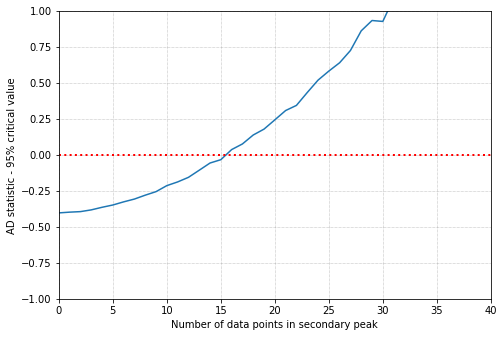

In [120]:
#Anderson-Darling test results
#---------------------------------------------------------------
#Create the plot 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#We plot the curve here...
plt.plot(ADcurve);
#...and let's add a line for cutoff
#Once AD curve we defined above crosses zero
#we can then reject the null hypothesis at 95% confidence
plt.plot(ADcurve*0,'r', linestyle='dotted', linewidth=2);
#Make nice
plt.xlabel('Number of data points in secondary peak')
plt.ylabel('AD statistic - 95% critical value')
#Add some grid lines and dump to screen
plt.grid(color='gray', linestyle='dotted', linewidth=.5)
plt.grid(visible=True)
#Zoom in to see the plot details at the bottom
ax.set_ylim(-1, 1);
ax.set_xlim(0, 40);

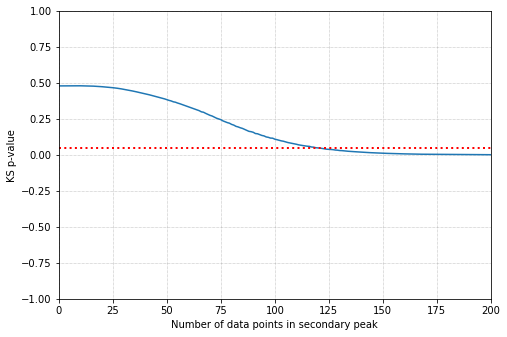

In [122]:
#Kolmogorov-Smirnov test results
#---------------------------------------------------------------
#Create the plot 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#We plot the curve here...
plt.plot(KScurve);
#...and let's add a line for cutoff
#Once KS curve we defined above crosses 0.05
#we can then reject the null hypothesis at 95% confidence
plt.plot(KScurve*0+0.05,'r', linestyle='dotted', linewidth=2);
#Make nice
plt.xlabel('Number of data points in secondary peak')
plt.ylabel('KS p-value')
#Add some grid lines and dump to screen
plt.grid(color='gray', linestyle='dotted', linewidth=.5)
plt.grid(visible=True)
#Zoom in to see the plot details at the bottom
ax.set_ylim(-1, 1);
ax.set_xlim(0, 200);

In [123]:
#The ability of AD and KS tests to resolve the second peak
#changes with the number of data points. The problem specified
#the data size of roughly 1e4... If the second peak is 100X smaller
#than the main peak then AD test will already see the difference but
#KS test will not. KS test starts to reject the null hypothesys of
#a single Gaussian peak at around 120 points in the second peak.
#AD starts to reject the null hypothesys at less than 15 points.
#The reason is that AD looks at area under the CDF curve with
#extra weight at the tails and KS looks at vertical deviation between
#ECDF and CDF curved without weights for distribution tails so KS is 
#just not as sensitive to the second peak which we placed near the tail
#of the main peak.